# Deep Autoencoders

In this notebook, we will explore autoencoders to perform the following three tasks

- Data compression
- Data generation
- Data interpolation

We will be using [MNIST digit dataset](https://en.wikipedia.org/wiki/MNIST_database), which is easily available through [`torchvision.datasets`](https://pytorch.org/vision/stable/datasets.html#torchvision.datasets.MNIST). 

### Setup

For this tutorial, we will need the following python packages 

1. numpy
2. matplotlib
3. torch
4. torchvision

Please follow the instructions [here](https://pytorch.org/) to install the last two libraries. 

In [1]:
# basic imports
import numpy as np
import matplotlib.pyplot as plt
import math
import pathlib

import torch
import torch.nn as nn
import torchvision
from torchvision import transforms

### Data

PyTorch has simple-to-use functions that downloads and loads the datasets. We will use these functions to streamline our deep learning pipeline.

Checkout other image datasets at [torch.datasets](https://pytorch.org/vision/stable/datasets.html).

In [2]:
# download data in data folder. It will create this folder if it doesn't exist
torchvision.datasets.MNIST(root="./data/", download=True)

100.0%


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



3.5%

102.8%


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100.0%


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



90.2%

112.7%
/Users/pgupta/anaconda3/envs/py39/lib/python3.9/site-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Processing...
Done!


Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data/
    Split: Train

### Explore Data

We will be carrying out simple investigations as we did in the practical of denoising autoencoders. 
Specifically, we are interested in finding out the following :

How does the data look like?

- What is the `type` of data?
- What does each element of data represent?
- What are the constituent parts of each element?
- How is the image represented?
- What do we use to plot an image?
- How do we use the image in our model?

In [4]:
# load data 
data = torchvision.datasets.MNIST(root="./data/", train=True) # only load training data

In [5]:
print("Type of data is the class\n", type(data))
print("Each element of the data is\n", type(data[0]))
print("A single element is\n", data[0],"first element is the image and the second element is the category")

Type of data is the class
 <class 'torchvision.datasets.mnist.MNIST'>
Each element of the data is
 <class 'tuple'>
A single element is
 (<PIL.Image.Image image mode=L size=28x28 at 0x131262670>, 5) first element is the image and the second element is the category


### Image data

We know that the image data is present in `PIL.Image.Image` format. We need to convert it to array of pixel values to operate on it. We will also be displaying these images. `matplotlib.pyplot` has a simple function `plt.imshow()` to display matrix as an image.

Raw image to tensor shape: torch.Size([1, 28, 28])
2D image tensor shape: torch.Size([28, 28])


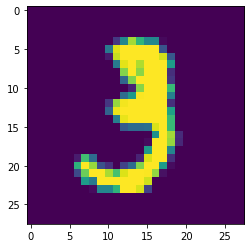

In [7]:
img = transforms.ToTensor()(data[10][0])
print(f"Raw image to tensor shape: {img.shape}")

# To plot this, we need a 2D array, so we use squeeze_(0) to remove first dimension
img = img.squeeze_(0)
print(f"2D image tensor shape: {img.shape}")

# how to display the image 
plt.imshow(img)

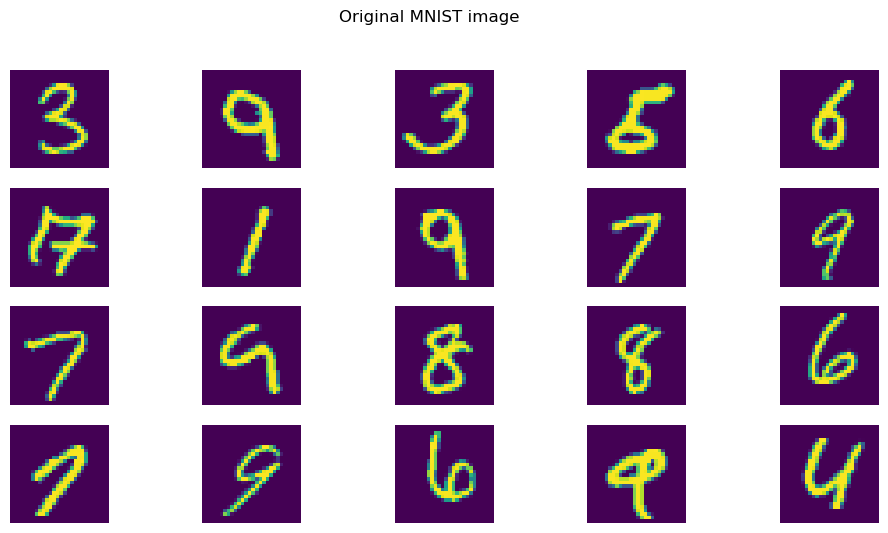

In [25]:
# visualize
n_samples = len(data)
n_vis = 20

nrows = 4
ncols = math.ceil(n_vis/nrows)
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12,6), dpi=100)

idxs = np.random.randint(low=0, high=n_samples, size=n_vis)

for i, idx in enumerate(idxs):
    ax = axs[i%nrows, i//nrows]
    img = transforms.ToTensor()(data[idx][0]).squeeze_(0)
    ax.imshow(img)
    ax.axis('off')

_ = fig.suptitle(f"Original MNIST dataset")


In [8]:
input_shape = img.shape

### Data Compression

We are interested in finding a compact representation for digits in our dataset. 
We will choose our latent dimension to be a 2D plane so that it's easy to visualize. 
However, depending on the usecase (e.g, classification, semi-supervised classification, etc.), one might choose a higher dimensional latent space.

To do this, we will build an autoencoder that comprises of an encoder and a decoder. 

In the following block of code, we will be implementing a simple **encoder**.
We will be using linear layers to process our images, although you are free to chose the architecture you like.

In [26]:
# vanilla autoenocder
class Encoder(nn.Module):
    def __init__(self, input_shape, latent_dim):
        super(Encoder, self).__init__()
        
        self.input_shape = input_shape 
        self.output_shape = latent_dim
        self.in_dim = input_shape[0] * input_shape[1]

        self.layers = nn.Sequential(
            nn.Linear(self.in_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 2)
            )

    def forward(self, x):
        input = x.reshape(-1, self.in_dim)
        return self.layers(input)

    def sample(self, x):
        # we will implement this in VAE
        pass

Decoder takes in its input as a vector in the latent space, and it outputs an image in the same space as that of the input. 
In the following block of code, we will implement a **decoder**.


In [27]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, output_shape):
        super(Decoder, self).__init__()
        
        self.output_shape = output_shape 
        self.latent_dim = latent_dim 
        self.out_dim = output_shape[0] * output_shape[1]
        
        self.layers = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, self.out_dim),
            nn.Sigmoid()
            )
    
    def forward(self, x):
        x = x.reshape(-1, self.latent_dim)
        return self.layers(x).reshape(-1, self.output_shape[0], self.output_shape[1])

Let's put these building blocks together to form an autoencoder

In [30]:
class Autoencoder(nn.Module):
    def __init__(self, input_shape, latent_dim):
        super(Autoencoder, self).__init__()
        
        self.input_shape = input_shape
        self.latent_dim = latent_dim
        self.encoder = Encoder(input_shape, latent_dim)
        self.decoder = Decoder(latent_dim, input_shape)
        
    
    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return z, x_hat

In [31]:
model_ae = Autoencoder(input_shape, 2)

### Dataset loading

PyTorch uses `torch.utils.data.Dataset` class to load data in parallel on multiple CPUs. It enables faster loading of the batch of data. It then uses `torch.utils.data.DataLoader` to combine these loaded data points together into a batch. These batches are then used as an input to the models.

For this reason, we need to customize `__len__` and `__getitem__` functions in the class. This will help us do any necessary preprocessing on the images before using them as an input to the model.

In [37]:
# create a dataset 
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data 
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        img = transforms.ToTensor()(self.data[index][0]).squeeze_(0)
        return img       

### Data splitting

We split the training dataset into train and validation. This will help us tune hyperparameters of the model. Note that hyperparameter tuning is not done in this tutorial. 

In [11]:
# split data into train and val; we will create train_data at the start of every epoch
x_train, x_val = torch.utils.data.random_split(data, [54000, 6000])
val_data = torch.utils.data.DataLoader(Dataset(x_val), batch_size=256, shuffle=True)

### Optimizer 

We will use the standard Adam optimzer to learn the parameters.

In [12]:
# define your optimizer. It is just a template. we will define it again later just before startig the training.
model = Autoencoder(input_shape)
optimizer = torch.optim.Adam(model.parameters())

### Loss 

We will create a function that will take following inputs:

1. Autoencoder instance
2. `torch.utils.data.DataLoader` instance 
3. optimizer (optional)

This function returns the mean loss on this data. 

In [39]:
def process(model, data, optimizer=None):
    n_samples = 0
    running_loss = 0
    for img, corrupted_img in data:
        # transfer to GPU if avaiable
        x = img.to(device)

        n_samples += img.shape[0]
        
        # forward pass
        z, x_hat = model(x)
        loss = nn.MSELoss()(x, x_hat) # reconstruction loss
        
        # backward pass 
        if optimizer is not None:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        running_loss += loss.item()
        
    return running_loss / n_samples
        

### Train

Finally, we will be running the training for `n_epochs` number of epochs. 
Each epoch consists of doing a backward pass on the subset of training data and evaluating the model on the validation data. 

**Note**: If one is concerned with good representation of the training data only (i.e., generalization outside training data is not of concern), we need not split our dataset into train and validation. 
However, in this tutorial, we will use the validation dataset to pick a model with the best generalization error. 

We will create a function `train` to conveniently call it with various models and loss functions that we can experiment with. 

In [14]:
def train(model, train_data, optimizer, process, title="")
    """
    Args:
        model (nn.Module): model to process the data
        data (torchvision.datasets): MNIST dataset
        optimizer (torch.optim): Optimizer of choice 
        process (fn): function defining how each epoch is handled
    
    Returns:
        best_model (nn.Module): returns the model with the best training loss 
        loss_plot (matplotlib.subplots): a plot for how training loss varied over the epochs
    """
    # fix seed for reproducibility 
    rng = np.random.RandomState(1)
    torch.manual_seed(rng.randint(np.iinfo(int).max))
    
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print("Using GPU:", device)
    else:
        device = torch.device("cpu")
        print("No GPU -> using CPU:", device)

    # create a model directory to store the best model
    model_dir = pathlib.Path("./models").resolve()
    if not model_dir.exists():
        model_dir.mkdir()

    model = Autoencoder(input_shape).to(device)
    optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

    epoch_size=200
    batch_size=128
    n_epochs = 30
    
    best_val_loss = np.inf
    no_improvement_cnt = 0 # early stopping
    val_losses = []
    train_losses = []
    for epoch in range(n_epochs):
        print(f"@ epoch {epoch}", end="")

        # training loss
        idxs = rng.choice(len(x_train), epoch_size * batch_size, replace=True)
        train_data = torch.utils.data.DataLoader(Dataset([train_data[idx] for idx in idxs]), batch_size=batch_size, num_workers=4)
        train_loss = process(model, train_data, optimizer)
        
        # evaluate
        with torch.no_grad():
            val_loss = process(model, val_data)
        
        # save the best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), model_dir / "best.ckpt")
        else:

            # if there has been no improvement in validation loss, stop early
            no_improvement_cnt += 1

            if no_improvement_cnt % 10 == 0:
                print("\nEarly stopping!")
                break
    
        # logging
        val_losses.append(val_loss)
        train_losses.append(train_loss)
        print(f"\ttrain_loss: {train_loss: .5f} val_loss: {val_loss: .5f}")

    # load the best model
    model = model.__class__(model.input_shape, model.latent_dim)
    model.load_state_dict(torch.load(model_dir / "best.ckpt"))
    model = model.to(device)


    # plot losses
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10,5), dpi=100)

    axs.plot(train_losses, color="#BDD9BF", marker="x", label="Train loss")
    axs.plot(val_losses, color="#A997DF", marker="o",, label="Val loss")
    axs.set_xlabel("Epochs", fontsize=20)
    axs.legend(prop={"size":15})

    # tick size
    for tick in axs.xaxis.get_major_ticks():
        tick.label.set_fontsize(15)

    for tick in axs.yaxis.get_major_ticks():
        tick.label.set_fontsize(15)
        
    fig.suptitle(f"{title}")

    return model

Using GPU: cuda
@ epoch 0	train_loss:  0.00050, val_loss: 0.00015
@ epoch 1	train_loss:  0.00024, val_loss: 0.00010
@ epoch 2	train_loss:  0.00019, val_loss: 0.00009
@ epoch 3	train_loss:  0.00017, val_loss: 0.00009
@ epoch 4	train_loss:  0.00017, val_loss: 0.00008
@ epoch 5	train_loss:  0.00016, val_loss: 0.00008
@ epoch 6	train_loss:  0.00015, val_loss: 0.00008
@ epoch 7	train_loss:  0.00015, val_loss: 0.00008
@ epoch 8	train_loss:  0.00014, val_loss: 0.00007
@ epoch 9	train_loss:  0.00014, val_loss: 0.00007
@ epoch 10	train_loss:  0.00014, val_loss: 0.00007
@ epoch 11	train_loss:  0.00013, val_loss: 0.00007
@ epoch 12	train_loss:  0.00013, val_loss: 0.00007
@ epoch 13	train_loss:  0.00013, val_loss: 0.00007
@ epoch 14	train_loss:  0.00013, val_loss: 0.00007
@ epoch 15	train_loss:  0.00013, val_loss: 0.00007
@ epoch 16	train_loss:  0.00012, val_loss: 0.00006
@ epoch 17	train_loss:  0.00012, val_loss: 0.00006
@ epoch 18	train_loss:  0.00012, val_loss: 0.00006
@ epoch 19	train_loss:  0

### Data Generation

### Data Interpolation